In [1]:
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 44.1MB/s 
     |████████████████████████████████| 3.1MB 31.6MB/s 
     |████████████████████████████████| 501kB 45.2MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


# General setup

In [0]:


# def get_t_network_general(x, y, hidden=100):
#   x_shape = keras.backend.int_shape(x)
#   y_shape = keras.backend.int_shape(y)
  
#   x = keras.layers.Flatten()(x)
#   y = keras.layers.Flatten()(y)
  
#   x = keras.layers.Dense(hidden)(x)
#   y = keras.layers.Dense(hidden)(y)
  
#   t = keras.layers.concatenate([x, y])
#   t = keras.layers.Dense(hidden)(t)
#   t = keras.layers.Dense(1)(t)
#   return t



def get_t_network_general(x, y_actual, y_random, hidden=100):
  
  
  model_x = keras.models.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
  ])
  
  model_y = keras.models.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
  ])
  
  x_hidden = model_x(x)
  y_actual_hidden = model_y(y_actual)
  y_random_hidden = model_y(y_random)
  
  t_actual = keras.layers.concatenate([x_hidden, y_actual_hidden])
  t_random = keras.layers.concatenate([x_hidden, y_random_hidden])
  
  model_t = keras.models.Sequential([
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
      keras.layers.Dense(1)
  ])
  
  t_actual = model_t(t_actual)
  t_random = model_t(t_random)
  return t_actual, t_random

def get_v_network(t_actual, t_random):
  v = keras.backend.mean(t_actual) - keras.backend.log(keras.backend.mean(keras.backend.exp(t_random)))
  return v

In [0]:
def get_general_data(data_size, dim, correlation=0.0):
  var = 0.2
  mean = np.zeros(dim + dim)
  
  cov = np.eye(dim * 2)
  
  cov[dim:, :dim] += np.flip(np.eye(dim), axis=0) * correlation
  cov[:dim, dim:] += np.flip(np.eye(dim), axis=0) * correlation

  x_y = np.expand_dims(np.random.multivariate_normal(mean, cov, data_size), axis=-1)
  x = x_y[:, :dim]
  actual_y = x_y[:, dim:]
  
  random_x_y = np.expand_dims(np.random.multivariate_normal(mean, cov, data_size), axis=-1)
  random_y = random_x_y[:, dim:]
  

  return {
      'x_input': x,
      'actual_y_input': actual_y,
      'random_y_input': random_y,
  }


[[ 1.   0.   0.  -0.9]
 [ 0.   1.  -0.9  0. ]
 [ 0.  -0.9  1.   0. ]
 [-0.9  0.   0.   1. ]]
[[ 1.   0.   0.  -0.9]
 [ 0.   1.  -0.9  0. ]
 [ 0.  -0.9  1.   0. ]
 [-0.9  0.   0.   1. ]]
[[ 1.   0.   0.  -0.9]
 [ 0.   1.  -0.9  0. ]
 [ 0.  -0.9  1.   0. ]
 [-0.9  0.   0.   1. ]]
Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 100us/sample - loss: -1.3285
Epoch 2/10
10000/10000 [==============================] - 1s 81us/sample - loss: -1.5660
Epoch 3/10
10000/10000 [==============================] - 1s 78us/sample - loss: -1.5696
Epoch 4/10
10000/10000 [==============================] - 1s 82us/sample - loss: -1.6506
Epoch 5/10
10000/10000 [==============================] - 1s 79us/sample - loss: -1.6808
Epoch 6/10
10000/10000 [==============================] - 1s 77us/sample - loss: -1.6755
Epoch 7/10
10000/10000 [==============================] - 1s 78us/sample - loss: -1.6955
Epoch 8/10
10000/10000 [==============================] - 1s 76us/sample -

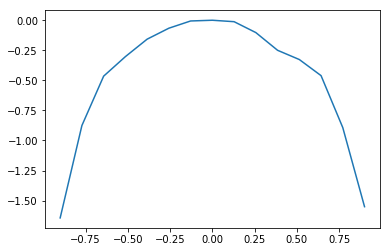

In [35]:
correlations = np.linspace(-0.9,0.9,15)
corr_score = []


for correlation in correlations:

  x_shape = (2, 1)
  y_shape = (2, 1)

  train_data_size = 10000
  test_data_size = train_data_size // 10

  x_train = get_general_data(train_data_size, dim=x_shape[0], correlation=correlation)
  y_train = np.zeros(train_data_size)
  x_test = get_general_data(test_data_size, dim=x_shape[0], correlation=correlation)
  y_test = np.zeros(test_data_size)
  x_tiny = get_general_data(1, dim=x_shape[0], correlation=correlation)
  y_tiny = np.zeros(1)

  x_input = keras.layers.Input(shape=x_shape, dtype='float', name='x_input')
  actual_y_input = keras.layers.Input(shape=y_shape, dtype='float', name='actual_y_input')
  random_y_input = keras.layers.Input(shape=y_shape, dtype='float', name='random_y_input')

  # t_actual = get_t_network_general(x_input, actual_y_input)
  # t_random = get_t_network_general(x_input, random_y_input)
  t_actual, t_random = get_t_network_general(x_input, actual_y_input, random_y_input)

  v = get_v_network(t_actual, t_random)

  # TODO: the gradient of v is biased. I am not sure how to use the moving average
  # yet exactly.

  model = keras.models.Model(inputs=[x_input, actual_y_input, random_y_input], outputs=[v])
  # optimizer = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
  optimizer = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None)


  def neg_identity_loss(y_true, y_pred):
    # Maximize.
    return -y_pred

  model.compile(
    optimizer=optimizer,
    loss=neg_identity_loss,
  #   metrics=[tf.keras.metrics.Mean()]
  )

  model.fit(x_train, y_train, epochs=10, batch_size=32)
  score = model.evaluate(x_test, y_test, batch_size=32)
  print('test score: ', score)
  
  corr_score.append(score)



In [0]:

  
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(correlations, corr_score, color='tab:blue')


In [0]:
# t_predict = keras.backend.function(
#     inputs=[x_input, actual_y_input, random_y_input], outputs=[t_actual, t_random])

# t_predict_output = t_predict(
#     [x_test['x_input'], x_test['actual_y_input'], 
#      x_test['random_y_input'],])


# v_predict = keras.backend.function(
#     inputs=[x_input, actual_y_input, random_y_input], outputs=[v])
# v_predict_output = v_predict(
#     [x_tiny['x_input'], x_tiny['actual_y_input'], 
#      x_tiny['random_y_input'],])


# v_predict_output_test = v_predict(
#     [x_test['x_input'], x_test['actual_y_input'], 
#      x_test['random_y_input'],])


# Exp 1

In [0]:
class Env(object):
  def __init__(self):
    self.state_space = (3, 1)
    self.action_space = (2, 1)
    
  def get_data(self, n, correlation=0.0):
    
    ret = {
        'state': [],
        'actual_action': [],
        'next_state': [],
    }
    for i in range(n):
      state = np.random.rand(*self.state_space)
      action = np.random.rand(*self.action_space)
      
      next_state = np.random.rand(*self.state_space)
      
#       if action[0,0] > 0.5 and action[1,0] > 0.5:
#         next_state = np.random.rand(*self.state_space)
#       else:
#         next_state = np.random.rand(*self.state_space) / 2 + 0.5
      
      ret['state'].append(state)
      ret['actual_action'].append(action)
      ret['next_state'].append(next_state)
      
    ret['state'] = np.array(ret['state'])
    ret['actual_action'] = np.array(ret['actual_action'])
    ret['next_state'] = np.array(ret['next_state'])
    ret['random_action'] = self.get_random_action(n)
    
    return ret
  
  def get_random_action(self, n):
    action = np.random.rand(*((n,) + self.action_space))
    return action

        
    

In [0]:
def get_predicted_next_state(state, action):
  state_shape = keras.backend.int_shape(state)
  action_shape = keras.backend.int_shape(action)
  
  state = keras.backend.expand_dims(state, axis=-2)
  action = keras.backend.expand_dims(action, axis=-3)
  state = tf.keras.backend.repeat_elements(state, rep=action_shape[1], axis=-2)
  action = tf.keras.backend.repeat_elements(action, rep=state_shape[1], axis=-3)
  state_action = keras.layers.concatenate([state, action])
  next_state = keras.layers.Dense(state_shape[-1])(state_action)
  
  next_state = tf.keras.backend.sum(next_state, axis=-2)
  
  return next_state


def get_t_network(state, actual_action, next_state, random_action, hidden=100):
  
  
  model_x = keras.models.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
  ])
  
  model_y = keras.models.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
  ])
  
  x = keras.layers.concatenate([state, next_state])
  
  
  x_hidden = model_x(x)
  y_actual_hidden = model_y(actual_action)
  y_random_hidden = model_y(random_action)
  
  t_actual = keras.layers.concatenate([x_hidden, y_actual_hidden])
  t_random = keras.layers.concatenate([x_hidden, y_random_hidden])
  
  model_t = keras.models.Sequential([
      keras.layers.Dense(hidden),
      keras.layers.LeakyReLU(),
      keras.layers.Dense(1)
  ])
  
  t_actual = model_t(t_actual)
  t_random = model_t(t_random)
  return t_actual, t_random
  # We assume (naively) that action will cause a diff from state -> next state.
  # this may not be true for more complicated transition functions.
  
  # Or ... we don't have to be that complicated... we just need T(s,a,s') -> R
  # So why don't we do f(s,a) -> s_pred and then dot(s_pred, s') -> R
  
  # the network to do f(s,a) -> s_pred is to first convert 
  # (3, m), (2, n) into (3, 2, m+n), then do fc to (3, 2, m)
  # finally add the dim 2 together (assuming that each action dim contributes)
  # independently to the next state to get (3, m) again, which is the next state
  
  # I adopted an RL-agonistic model...


def get_v_network(t_actual, t_random):
  v = keras.backend.mean(t_actual) - keras.backend.log(keras.backend.mean(keras.backend.exp(t_random)))
  return v

In [49]:
correlations = np.linspace(-0.9,0.9,15)
corr_score = []


for correlation in correlations:

  state_space = (3,1)
  action_space = (2,1)

  train_data_size = 10000
  test_data_size = train_data_size // 10

  env = Env()
  x_train = env.get_data(train_data_size, correlation=correlation)
  y_train = np.zeros(train_data_size)
  x_test = env.get_data(test_data_size, correlation=correlation)
  y_test = np.zeros(test_data_size)
  x_tiny = env.get_data(1, correlation=correlation)
  y_tiny = np.zeros(1)

#   x_input = keras.layers.Input(shape=x_shape, dtype='float', name='x_input')
#   actual_y_input = keras.layers.Input(shape=y_shape, dtype='float', name='actual_y_input')
#   random_y_input = keras.layers.Input(shape=y_shape, dtype='float', name='random_y_input')
#   t_actual, t_random = get_t_network_general(x_input, actual_y_input, random_y_input)

#   v = get_v_network(t_actual, t_random)


  state = keras.layers.Input(shape=state_shape, dtype='float', name='state')
  actual_action = keras.layers.Input(shape=action_shape, dtype='float', name='actual_action')
  random_action = keras.layers.Input(shape=action_shape, dtype='float', name='random_action')
  next_state = keras.layers.Input(shape=state_shape, dtype='float', name='next_state')

  t_actual, t_random = get_t_network(state, actual_action, next_state, random_action)

  v = get_v_network(t_actual, t_random)


  # TODO: the gradient of v is biased. I am not sure how to use the moving average
  # yet exactly.

  model = keras.models.Model(inputs=[state, actual_action, random_action, next_state], outputs=[v])
  optimizer = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None)


  def neg_identity_loss(y_true, y_pred):
    # Maximize.
    return -y_pred

  model.compile(
    optimizer=optimizer,
    loss=neg_identity_loss,
  #   metrics=[tf.keras.metrics.Mean()]
  )

  model.fit(x_train, y_train, epochs=10, batch_size=32)
  score = model.evaluate(x_test, y_test, batch_size=32)
  print('test score: ', score)
  
  corr_score.append(score)
  break



Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 109us/sample - loss: 0.0017
Epoch 2/10
10000/10000 [==============================] - 1s 93us/sample - loss: 5.5707e-04
Epoch 3/10
10000/10000 [==============================] - 1s 80us/sample - loss: 4.3522e-04
Epoch 4/10
10000/10000 [==============================] - 1s 80us/sample - loss: -1.8036e-04
Epoch 5/10
10000/10000 [==============================] - 1s 84us/sample - loss: 1.4469e-05
Epoch 6/10
10000/10000 [==============================] - 1s 86us/sample - loss: -4.3617e-05
Epoch 7/10
10000/10000 [==============================] - 1s 79us/sample - loss: -5.5834e-05
Epoch 8/10
10000/10000 [==============================] - 1s 77us/sample - loss: -3.2271e-05
Epoch 9/10
10000/10000 [==============================] - 1s 83us/sample - loss: -6.2067e-05
Epoch 10/10
1000/1000 [==============================] - 0s 100us/sample - loss: 8.7205e-04
test score:  0.0008720472157001495
